# Topic Modeling

In [1]:
import pandas as pd
import numpy as np
import gensim
import re

C:\Users\rebeccamukena\anaconda3\lib\site-packages\gensim\similarities\__init__.py:15: UserWarning: The gensim.similarities.levenshtein submodule is disabled, because the optional Levenshtein package <https://pypi.org/project/python-Levenshtein/> is unavailable. Install Levenhstein (e.g. `pip install python-Levenshtein`) to suppress this warning.
  warnings.warn(msg)


### 1. Data Pre-Processing

In [2]:
df = pd.read_csv('AirCanada_review_raw.csv')
df = df.drop(df.columns[0], axis=1)
df.head()

,title,user,user_type,review,publish_date,Type Of Traveller,Seat Type,Route,Date Flown,Seat Comfort,Cabin Staff Service,Food & Beverages,Inflight Entertainment,Ground Service,Wifi & Connectivity,Value For Money,page
0,24 hour delay which was not acceptable,Tony Harris,TripVerified,Flight from Sydney to Montreal cancelled on ...,6th February 2022,Business,Economy Class,Toronto to Vancouver,February 2022,1,1,0,0,1,0,1,1
1,Worst airline ever,S Deane,TripVerified,Air Canada’s website booked me with another ...,3rd February 2022,Solo Leisure,Economy Class,Tokyo to Seattle via Seoul / Vancouver,February 2022,0,0,0,0,0,0,1,1
2,the staff had no power to act,Collins Mazraani,TripVerified,I had booked business class for my mother an...,27th January 2022,Family Leisure,Economy Class,London to Montreal,January 2022,2,3,1,2,1,4,2,1
3,Absolutely the worst airline,Shawn Holden,NotVerified,Houston to Prince George. They cancelled my f...,25th January 2022,Family Leisure,Economy Class,Houston to Prince George,February 2021,1,1,0,0,1,0,1,1
4,I was not reimbursed for charges,G Ragami,TripVerified,Air Canada cancelled my flights twice so I h...,18th January 2022,Solo Leisure,Economy Class,Saskatoon to Chicago via Toronto,December 2021,2,2,2,0,1,0,1,1


In [3]:
df.columns

Index(['title', 'user', 'user_type', 'review', 'publish_date',
       'Type Of Traveller', 'Seat Type', 'Route', 'Date Flown', 'Seat Comfort',
       'Cabin Staff Service', 'Food & Beverages', 'Inflight Entertainment',
       'Ground Service', 'Wifi & Connectivity', 'Value For Money', 'page'],
      dtype='object')

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1644 entries, 0 to 1643
Data columns (total 17 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   title                   1644 non-null   object
 1   user                    1644 non-null   object
 2   user_type               1644 non-null   object
 3   review                  1644 non-null   object
 4   publish_date            1644 non-null   object
 5   Type Of Traveller       1205 non-null   object
 6   Seat Type               1644 non-null   object
 7   Route                   1201 non-null   object
 8   Date Flown              1202 non-null   object
 9   Seat Comfort            1644 non-null   int64 
 10  Cabin Staff Service     1644 non-null   int64 
 11  Food & Beverages        1644 non-null   int64 
 12  Inflight Entertainment  1644 non-null   int64 
 13  Ground Service          1644 non-null   int64 
 14  Wifi & Connectivity     1644 non-null   int64 
 15  Valu

In [5]:
df['user_type'].value_counts()

Not Verified                        693
TripVerified                        579
VerifiedReview                      255
NotVerified                         116
TorontotoClevelandVerifiedReview      1
Name: user_type, dtype: int64

In [6]:
df['Type Of Traveller'].value_counts()

Solo Leisure      444
Couple Leisure    292
Family Leisure    243
Business          226
Name: Type Of Traveller, dtype: int64

In [7]:
df['Seat Type'].value_counts()

Economy Class      1286
Business Class      262
Premium Economy      83
First Class          13
Name: Seat Type, dtype: int64

In [8]:
df['month_flown'] = df['Date Flown'].apply(lambda x: str(x).split()[0] if str(x).split()[0] != 'nan' else np.NaN)
df['year_flown'] = df['Date Flown'].apply(lambda x: str(x).split()[1] if len(str(x).split()) > 1 else np.NaN)

print(df['month_flown'].head())
print(df['year_flown'].head())

0    February
1    February
2     January
3    February
4    December
Name: month_flown, dtype: object
0    2022
1    2022
2    2022
3    2021
4    2021
Name: year_flown, dtype: object


In [9]:
df['month_flown'].value_counts()

July         144
August       134
December     126
September    106
October      103
January      102
February      95
November      93
June          93
March         74
May           67
April         65
Name: month_flown, dtype: int64

In [10]:
df['year_flown'].value_counts()

2019    255
2018    239
2016    187
2017    183
2015    162
2020     96
2021     68
2022      9
2014      3
Name: year_flown, dtype: int64

In [11]:
# Remove punctuation
df['title_processed'] = df['title'].map(lambda x: re.sub('[,\.!?]', '', x))
df['review_processed'] = df['review'].map(lambda x: re.sub('[,\.!?]', '', x))

# Convert the titles to lowercase
df['title_processed'] = df['title_processed'].map(lambda x: x.lower())
df['review_processed'] = df['review_processed'].map(lambda x: x.lower())

print(df['title_processed'].head())
df['review_processed'].head()

0    24 hour delay which was not acceptable
1                        worst airline ever
2             the staff had no power to act
3              absolutely the worst airline
4          i was not reimbursed for charges
Name: title_processed, dtype: object


0      flight from sydney to montreal cancelled on ...
1      air canada’s website booked me with another ...
2      i had booked business class for my mother an...
3     houston to prince george they cancelled my fl...
4      air canada cancelled my flights twice so i h...
Name: review_processed, dtype: object

### 2. Data Exploration

In [12]:
from wordcloud import WordCloud
import gensim
from gensim.utils import simple_preprocess
import nltk
from nltk.corpus import stopwords
import gensim.corpora as corpora
from pprint import pprint

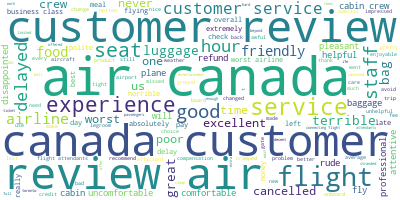

In [13]:
# Wordcloud
title_string = ','.join(list(df['title_processed'].values))
wordcloud = WordCloud(background_color="white", max_words=5000, contour_width=3, contour_color='steelblue')

wordcloud.generate(title_string)
wordcloud.to_image()

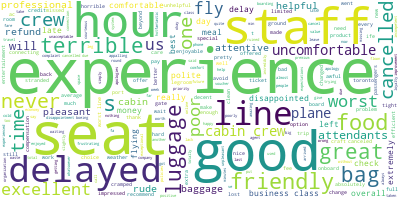

In [14]:
# filter out a few words
sw = ['canada', 'air', 'customer', 'review', 'service', 'flight']
for w in sw:
    title_string = title_string.replace(w, "")

wordcloud.generate(title_string)
wordcloud.to_image()

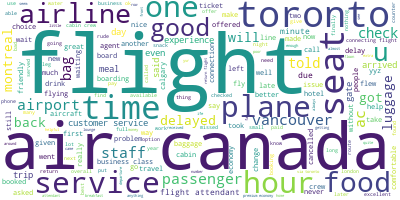

In [15]:
review_string = ','.join(list(df['review_processed'].values))
wordcloud.generate(review_string)
wordcloud.to_image()

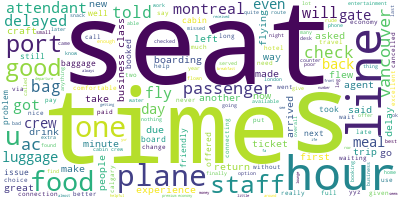

In [16]:
sw.append('toronto')
for w in sw:
    review_string = review_string.replace(w, "")

wordcloud.generate(review_string)
wordcloud.to_image()

### Analysis and Insights

The wordclouds show there are all kinds of themes in these reviews (delays, food, customer service, good and bad experiences). Our next setp would be to identify the main topics. In addition, we can observe that there are a few additional stopwords to remove before we proceed.

### 3. Topic Selection

### 3.1 Document Topic Modeling

In [17]:
stop_words = stopwords.words('english')
stop_words.extend(['canada', 'air', 'customer', 'review', 'service', 'flight', 'toronto', 'one', 'would', 's', 'us', 
                   'could'])

def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True)) # deacc=True removes punctuations

def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) 
             if word not in stop_words] for doc in texts]

In [18]:
def topic_generator(dfcol, num_topics):
    data = dfcol.values.tolist()
    data_words = list(sent_to_words(data))
    data_words = remove_stopwords(data_words)
    # print(data_words[:1][0][:30])

    id2word = corpora.Dictionary(data_words)
    texts = data_words
    corpus = [id2word.doc2bow(text) for text in texts]
    # print(corpus[:1][0][:30])

    lda_model = gensim.models.LdaMulticore(corpus=corpus, id2word=id2word, num_topics=num_topics)
    pprint(lda_model.print_topics())
    doc_lda = lda_model[corpus]

In [19]:
# TOPICS FROM REVIEWS
topic_generator(df.review_processed, 5)

[(0,
  '0.009*"time" + 0.005*"got" + 0.005*"staff" + 0.005*"ac" + 0.005*"gate" + '
  '0.005*"vancouver" + 0.005*"good" + 0.005*"seat" + 0.005*"flights" + '
  '0.005*"check"'),
 (1,
  '0.008*"get" + 0.008*"time" + 0.007*"seat" + 0.006*"hours" + 0.006*"ac" + '
  '0.005*"plane" + 0.005*"luggage" + 0.005*"vancouver" + 0.005*"airport" + '
  '0.005*"flights"'),
 (2,
  '0.008*"time" + 0.007*"hours" + 0.007*"vancouver" + 0.006*"seats" + '
  '0.006*"food" + 0.006*"ac" + 0.006*"back" + 0.006*"good" + 0.006*"delayed" + '
  '0.005*"flights"'),
 (3,
  '0.007*"time" + 0.007*"flights" + 0.007*"ac" + 0.007*"seat" + 0.006*"staff" '
  '+ 0.006*"food" + 0.005*"even" + 0.005*"airline" + 0.005*"crew" + '
  '0.005*"good"'),
 (4,
  '0.009*"time" + 0.008*"seat" + 0.007*"flights" + 0.006*"seats" + '
  '0.006*"staff" + 0.006*"plane" + 0.006*"crew" + 0.006*"get" + 0.006*"good" + '
  '0.005*"class"')]


### Analysis and Insights

It is hard to derive the true insights from the reviews as word proportions are very low. Let's try with the reviews titles as they are more concise.

In [28]:
# TOPIC FROM TITLES
topic_generator(df.title_processed, 4)

[(0,
  '0.023*"crew" + 0.018*"cabin" + 0.018*"hours" + 0.015*"good" + '
  '0.012*"disappointed" + 0.011*"friendly" + 0.010*"food" + 0.008*"delayed" + '
  '0.008*"luggage" + 0.008*"get"'),
 (1,
  '0.039*"experience" + 0.025*"good" + 0.021*"staff" + 0.013*"attendants" + '
  '0.011*"pleasant" + 0.011*"seats" + 0.010*"luggage" + 0.010*"comfortable" + '
  '0.009*"never" + 0.009*"overall"'),
 (2,
  '0.026*"delayed" + 0.018*"seat" + 0.018*"cancelled" + 0.014*"airline" + '
  '0.014*"uncomfortable" + 0.013*"time" + 0.010*"flights" + 0.010*"hour" + '
  '0.010*"extremely" + 0.010*"helpful"'),
 (3,
  '0.026*"worst" + 0.020*"experience" + 0.018*"terrible" + 0.018*"airline" + '
  '0.016*"staff" + 0.016*"excellent" + 0.015*"food" + 0.013*"class" + '
  '0.011*"poor" + 0.011*"good"')]


### Analysis and Insights

Topics: 
- 0: good experience: good crew and cabin, although there might be delays
- 1: great experience: good experience with staff and crew overall
- 2: bad experience: delays, cancellations and uncomfortable seats
- 3: mixed experience: terrible experience but the staff and food were excellent

Overall, the staff, crew and cabin are doing a great job and the customers recognize and appreciate their efforts despite the difficulties that they moght face during their experience with Air Canada.

### 3.2 Topics by Customer Segments

In [21]:
# topics by user types
for user in df.user_type.unique():
    temp_df = df.loc[df['user_type'] == user]
    print(user, ":")
    topic_generator(temp_df, 5)
    print('\n')

TripVerified :
[(0,
  '0.012*"time" + 0.010*"vancouver" + 0.010*"class" + 0.008*"economy" + '
  '0.007*"tripverified" + 0.007*"hours" + 0.007*"get" + 0.007*"seat" + '
  '0.006*"th" + 0.006*"good"'),
 (1,
  '0.010*"economy" + 0.008*"airline" + 0.008*"class" + 0.007*"hours" + '
  '0.006*"montreal" + 0.006*"time" + 0.006*"tripverified" + 0.006*"leisure" + '
  '0.005*"flights" + 0.005*"plane"'),
 (2,
  '0.011*"class" + 0.008*"time" + 0.008*"economy" + 0.007*"vancouver" + '
  '0.007*"business" + 0.007*"staff" + 0.007*"get" + 0.007*"flights" + '
  '0.007*"hours" + 0.006*"tripverified"'),
 (3,
  '0.008*"vancouver" + 0.007*"economy" + 0.007*"delayed" + 0.007*"hours" + '
  '0.007*"class" + 0.007*"get" + 0.007*"tripverified" + 0.007*"time" + '
  '0.006*"told" + 0.006*"th"'),
 (4,
  '0.007*"economy" + 0.007*"class" + 0.006*"time" + 0.006*"get" + '
  '0.006*"seats" + 0.005*"hour" + 0.005*"fly" + 0.005*"tripverified" + '
  '0.005*"hours" + 0.005*"vancouver"')]


NotVerified :
[(0,
  '0.008*"economy

In [22]:
# topics by type of traveller
for tot in df['Type Of Traveller'].unique()[0:4]:
    temp_df = df.loc[df['Type Of Traveller'] == tot]
    print(tot, ":")
    topic_generator(temp_df, 5)
    print('\n')

Business :
[(0,
  '0.013*"time" + 0.009*"business" + 0.007*"hours" + 0.007*"plane" + '
  '0.007*"hour" + 0.006*"montreal" + 0.006*"class" + 0.006*"airport" + '
  '0.005*"crew" + 0.005*"via"'),
 (1,
  '0.012*"business" + 0.011*"class" + 0.009*"time" + 0.007*"hours" + '
  '0.006*"staff" + 0.006*"economy" + 0.006*"check" + 0.006*"airline" + '
  '0.006*"seat" + 0.005*"agent"'),
 (2,
  '0.016*"business" + 0.012*"class" + 0.009*"time" + 0.008*"good" + '
  '0.007*"economy" + 0.007*"staff" + 0.006*"montreal" + 0.006*"hours" + '
  '0.006*"th" + 0.006*"airline"'),
 (3,
  '0.015*"business" + 0.013*"class" + 0.009*"economy" + 0.008*"time" + '
  '0.007*"vancouver" + 0.006*"hours" + 0.006*"food" + 0.006*"staff" + '
  '0.006*"flights" + 0.005*"plane"'),
 (4,
  '0.013*"business" + 0.009*"time" + 0.008*"class" + 0.007*"hours" + '
  '0.006*"delayed" + 0.006*"th" + 0.006*"ac" + 0.006*"experience" + '
  '0.006*"flights" + 0.006*"airline"')]


Solo Leisure :
[(0,
  '0.012*"time" + 0.010*"economy" + 0.008*"

In [23]:
# topics by seat types
for seat in df['Seat Type'].unique():
    temp_df = df.loc[df['Seat Type'] == seat]
    print(seat, ":")
    topic_generator(temp_df, 5)
    print('\n')

Economy Class :
[(0,
  '0.010*"economy" + 0.008*"class" + 0.008*"nan" + 0.007*"th" + 0.006*"hours" '
  '+ 0.006*"ac" + 0.006*"crew" + 0.006*"flights" + 0.006*"food" + '
  '0.006*"vancouver"'),
 (1,
  '0.010*"time" + 0.009*"economy" + 0.008*"class" + 0.008*"hours" + '
  '0.007*"told" + 0.007*"staff" + 0.007*"get" + 0.007*"nan" + 0.006*"hour" + '
  '0.006*"airline"'),
 (2,
  '0.012*"nan" + 0.010*"time" + 0.009*"economy" + 0.007*"class" + '
  '0.007*"flights" + 0.007*"th" + 0.007*"get" + 0.007*"vancouver" + '
  '0.006*"good" + 0.005*"ac"'),
 (3,
  '0.009*"economy" + 0.008*"seat" + 0.008*"plane" + 0.008*"class" + '
  '0.007*"flights" + 0.007*"time" + 0.006*"staff" + 0.006*"vancouver" + '
  '0.006*"get" + 0.005*"nan"'),
 (4,
  '0.011*"nan" + 0.008*"time" + 0.007*"th" + 0.007*"hours" + 0.007*"class" + '
  '0.006*"seats" + 0.006*"flights" + 0.006*"food" + 0.006*"economy" + '
  '0.005*"back"')]


Premium Economy :
[(0,
  '0.014*"premium" + 0.014*"economy" + 0.010*"flights" + 0.007*"seats" + '


In [24]:
# topics by year
for year in df['year_flown'].unique():
    temp_df = df.loc[df['year_flown'] == year]
    print(year, ":")
    topic_generator(temp_df, 5)
    print('\n')

2022 :
[(0,
  '0.021*"airline" + 0.013*"never" + 0.012*"ever" + 0.011*"de" + '
  '0.011*"booked" + 0.008*"business" + 0.008*"la" + 0.008*"le" + '
  '0.007*"february" + 0.007*"flown"'),
 (1,
  '0.013*"january" + 0.012*"got" + 0.011*"vancouver" + 0.010*"back" + '
  '0.010*"hour" + 0.009*"montreal" + 0.009*"business" + 0.009*"hours" + '
  '0.009*"min" + 0.008*"plane"'),
 (2,
  '0.014*"de" + 0.012*"montreal" + 0.012*"january" + 0.010*"le" + '
  '0.009*"business" + 0.009*"la" + 0.008*"hour" + 0.007*"plane" + 0.006*"et" + '
  '0.006*"airline"'),
 (3,
  '0.014*"baggage" + 0.013*"delayed" + 0.010*"hour" + 0.010*"montreal" + '
  '0.009*"connecting" + 0.008*"business" + 0.008*"de" + 0.007*"got" + '
  '0.007*"la" + 0.007*"told"'),
 (4,
  '0.022*"de" + 0.014*"business" + 0.013*"la" + 0.010*"le" + 0.008*"ils" + '
  '0.007*"pour" + 0.007*"montreal" + 0.007*"et" + 0.007*"mother" + 0.007*"qu"')]


2021 :
[(0,
  '0.009*"class" + 0.009*"told" + 0.009*"hour" + 0.008*"luggage" + '
  '0.007*"back" + 0.007*

ValueError: cannot compute LDA over an empty collection (no terms)

### Analysis and Insights

